In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import seaborn as sbn

In [2]:
import os
import sys 

path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''


def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import json
from factory_data import get_data, SQLDataSourceFactory
from factory_models import ModelContext, Modelos
from args_data_model import (
    ModelRNN,
    ModelBlockRNN,
    ModelExponentialSmoothing,
    ModelTCNModel,
    ModelFFT,
    ModelTransformerModel,
    ModelNBEATSModel,
    ModelDLinearModel,
    ModelNlinearModel,
    ModelTFTModel
)

attempted relative import with no known parent package


In [4]:
from factory_prepare_data import DataCleaner,MeanImputation,OutliersToIQRMean,DataModel

In [5]:
CONFIG_FILE = "/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/parameter/data_params_run.json"

with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = json.load(file)

print("Probando el estacion de datos de sql")
data_postgrest = get_data(SQLDataSourceFactory(**parameters))

Probando el estacion de datos de sql


In [7]:
#Reempplazo de los tipo de datos por lo cuales 
#se va a cambiar el dataframe
new_types =[np.datetime64,int,int,'object',int,int]

#Estrategias para imputar los datos faltantes de NA 
strategy = {
    int:np.mean,
    float:np.mean,
    object:stats.mode
}

#metodo para transformar los tipo de datos
replace = {
    int:lambda x: int(float(x.replace(',',''))),
    float:lambda x: float(x.replace(',',''))
}

In [8]:
imputation = MeanImputation(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters
)

cleaner = DataCleaner(imputation)
data_for_process = cleaner.clean(data_postgrest)
display(data_for_process.dataframe.head())

,Fecha Creación,Material (Cod),Peso neto (TON),Solicitate (Cod),Cant Pedido UMV,Valor Neto
0,2022-01-01,10011308,10,0004155696,200,3844
1,2022-01-02,10011308,10,0004158888,200,3939
2,2022-01-03,10059053,34,0004151082,34,11863
3,2022-01-03,10059053,33,0004139983,33,11346
4,2022-01-03,10059053,33,0004150188,33,11662


In [8]:
outliners = OutliersToIQRMean(
    **parameters
)
# outliners.clean(data_for_process.dataframe)
cleaner.strategy = outliners
filter_data = cleaner.clean(data_for_process.dataframe)

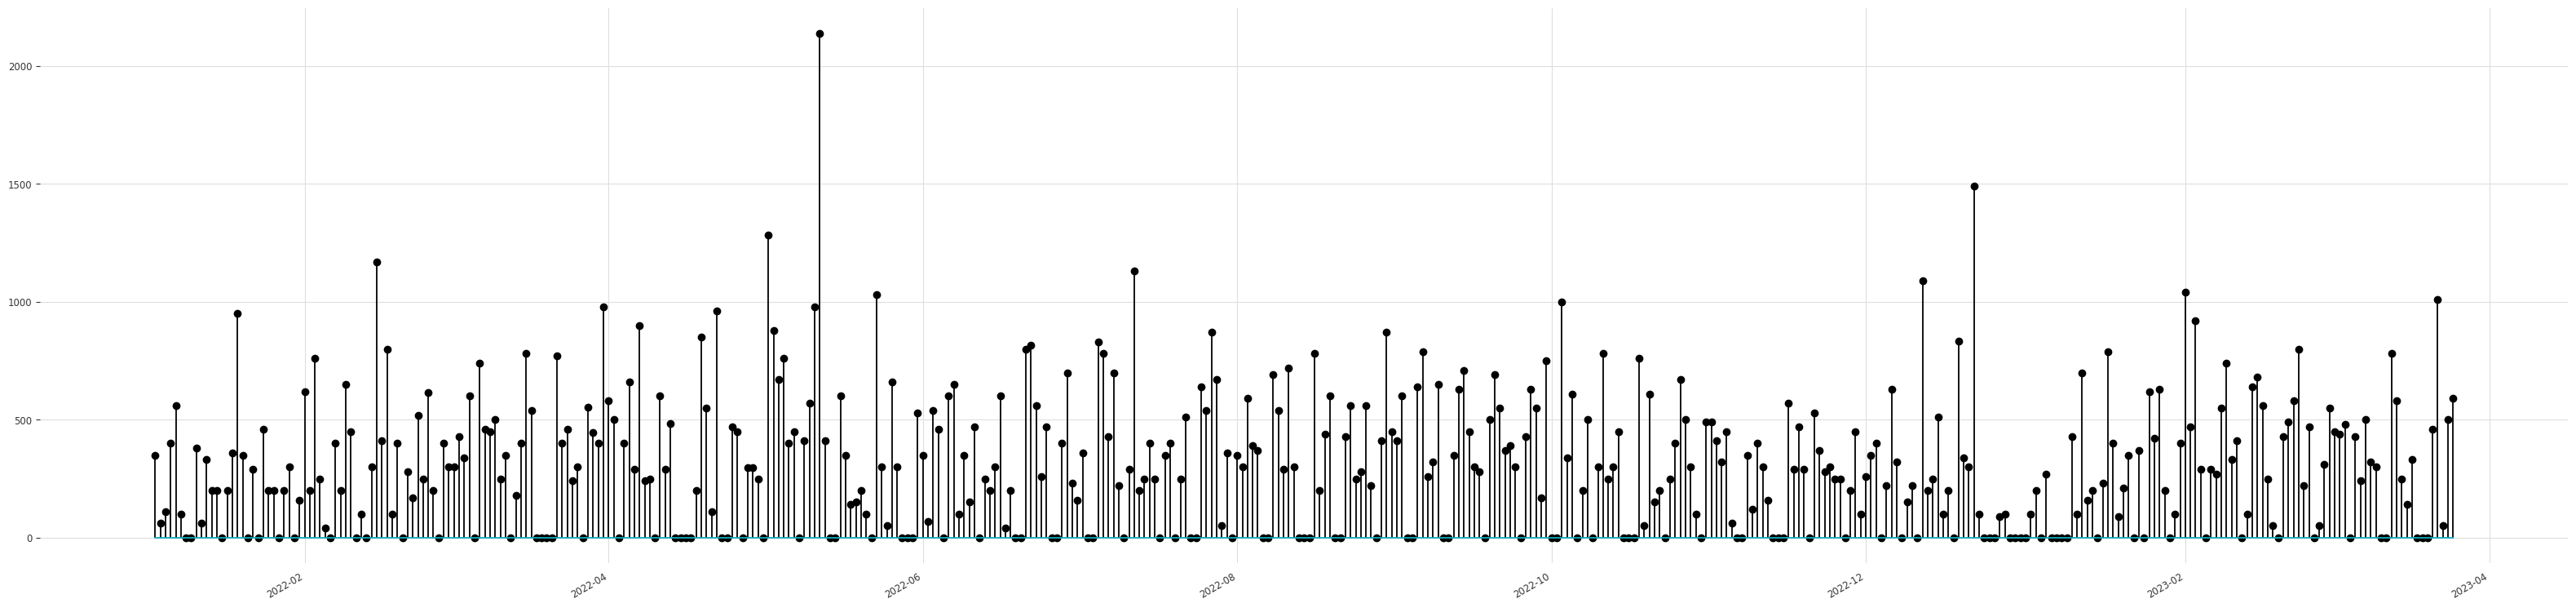

In [15]:
# CLIENTE = 10011308
# COL_FEATURE ='Material (Cod)'

# #Marcara para valores numericos
# MASK = data_for_process.dataframe[COL_FEATURE] == CLIENTE
# data_for_process.dataframe = data_for_process.dataframe[MASK].copy()

# CLIENTE = 4177452
# COL_FEATURE ='Solicitate (Cod)'

# #Mascara para datos string
# MASK = data_for_process.dataframe[COL_FEATURE].str.contains(str(CLIENTE))
# data_for_process.dataframe = data_for_process.dataframe[MASK]
# data_for_process.get_expand_date('Fecha Creación')
# data_for_process.set_index_col('Fecha Creación')
# data_for_process.group_by_time('Cant Pedido UMV',frequency_group='D')

# fig, ax = plt.subplots(figsize=(40,10))
# ax.stem(
#     data_for_process.dataframe.index,
#     data_for_process.dataframe['Cant Pedido UMV'].values)

# fmt_half_year = mdates.MonthLocator(interval=2)
# ax.xaxis.set_major_locator(fmt_half_year)
# fmt_month = mdates.MonthLocator()
# ax.xaxis.set_minor_locator(fmt_month)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# datemin =np.datetime64(data_for_process.dataframe.index.min(), 'Y')
# datemax =np.datetime64(data_for_process.dataframe.index.max(), 'Y')

# # ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.grid(True)
# fig.autofmt_xdate()
# plt.show()

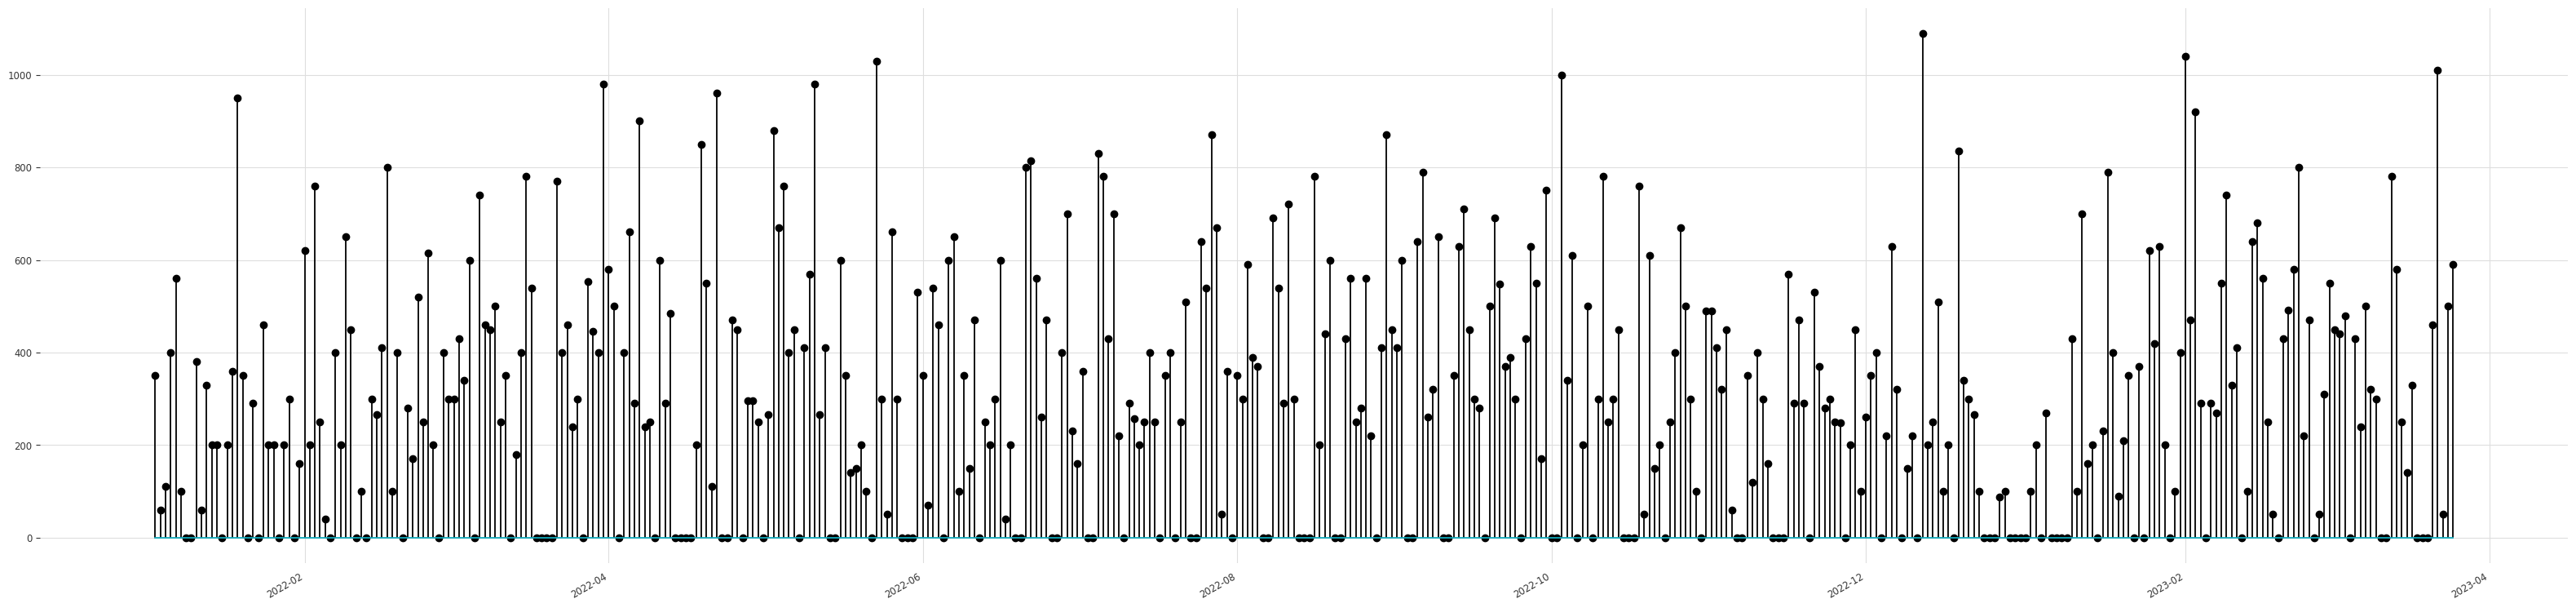

In [14]:
data = filter_data.copy()

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
mean_IQR = (Q1 + Q3) / 2
data_out = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR)))]
data_mode = data_out.fillna(mean_IQR)

fig, ax = plt.subplots(figsize=(40,10))
ax.stem(
    data_mode.index,
    data_mode['Cant Pedido UMV'].values)

fmt_half_year = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

datemin =np.datetime64(data_mode.index.min(), 'Y')
datemax =np.datetime64(data_mode.index.max(), 'Y')

# ax.set_xlim(datemin, datemax)
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.grid(True)
fig.autofmt_xdate()
plt.show()

2026.2499999999993 -1215.7499999999995


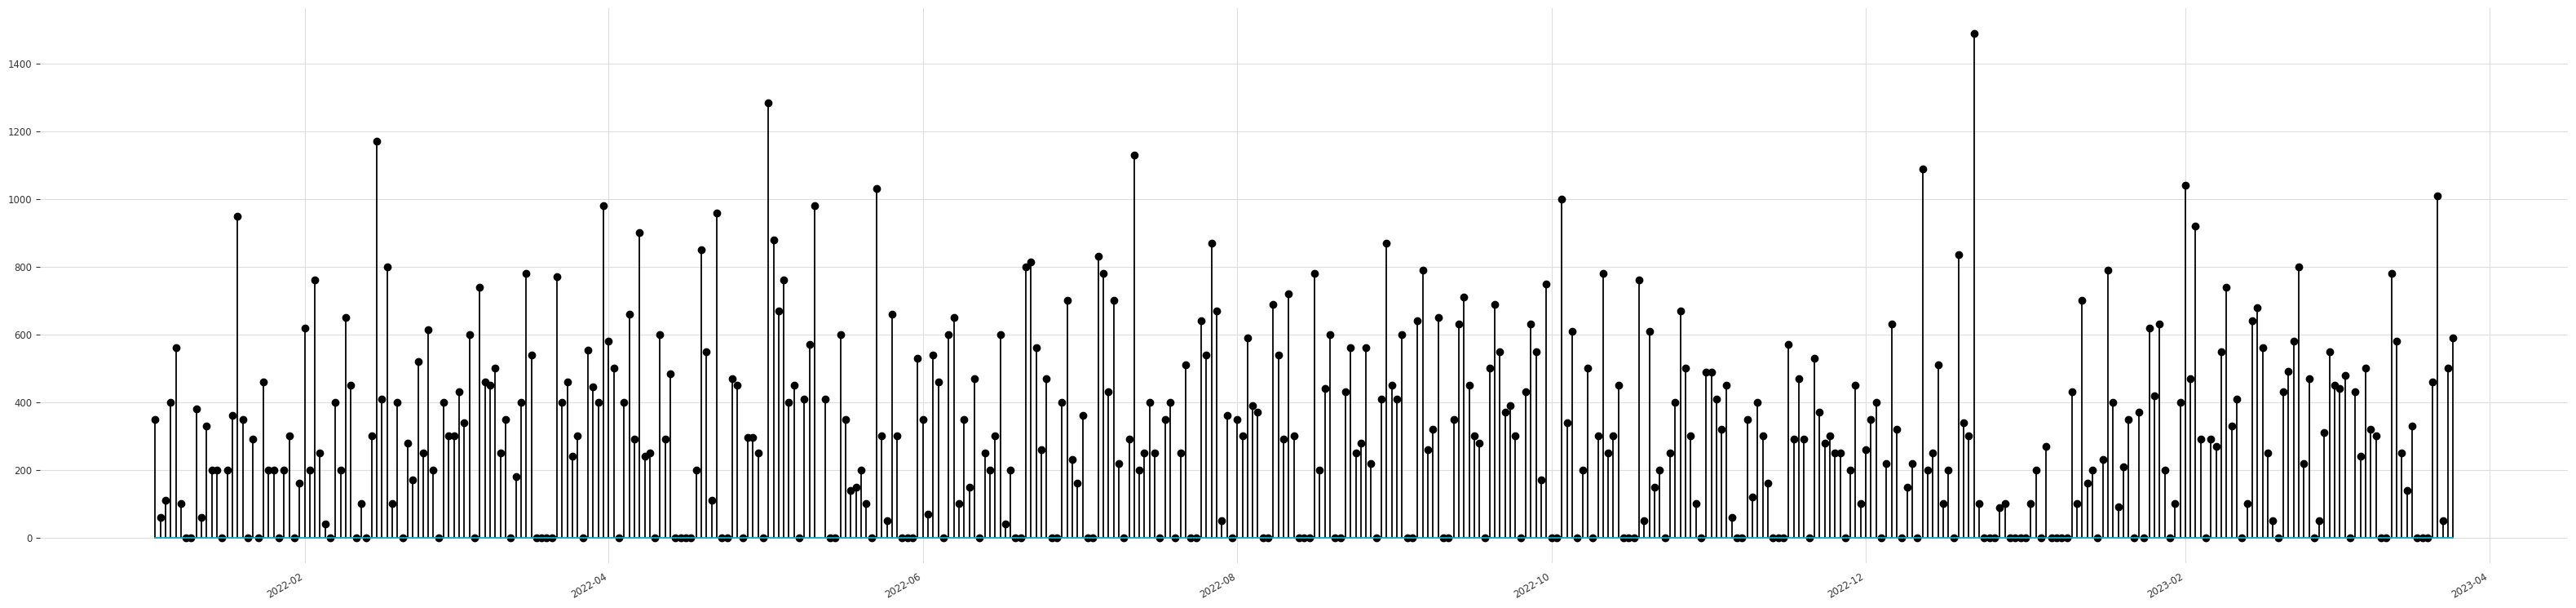

In [27]:
# data = data_for_process.dataframe.copy()

# data_max =0
# data_min = 0

# q75,q25 = np.percentile(data.loc[:,'Cant Pedido UMV'],[95,1])
# intr_qr = q75-q25

# data_max = q75+(1.5*intr_qr)
# data_min = q25-(1.5*intr_qr)

# print(data_max, data_min)

# data.loc[data['Cant Pedido UMV'] < data_min,'Cant Pedido UMV'] = np.nan
# data.loc[data['Cant Pedido UMV'] > data_max,'Cant Pedido UMV'] = np.nan

# data.isnull().sum()

# fig, ax = plt.subplots(figsize=(40,10))
# ax.stem(
#     data.index,
#     data['Cant Pedido UMV'].values)

# fmt_half_year = mdates.MonthLocator(interval=2)
# ax.xaxis.set_major_locator(fmt_half_year)
# fmt_month = mdates.MonthLocator()
# ax.xaxis.set_minor_locator(fmt_month)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# datemin =np.datetime64(data.index.min(), 'Y')
# datemax =np.datetime64(data.index.max(), 'Y')

# # ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.grid(True)
# fig.autofmt_xdate()
# plt.show()

In [30]:
# from sklearn.impute import KNNImputer

# data = data_for_process.dataframe.copy()

# imputer = KNNImputer(n_neighbors=15, weights='uniform', metric= 'nan_euclidean')
# imputer.fit(data.values)
# xtrans = imputer.transform(data.values)
# remove_outliners = pd.DataFrame({'Cant Pedido UMV':xtrans.squeeze()})
# data.loc[:,'Cant Pedido UMV'] = remove_outliners['Cant Pedido UMV'].values

# fig, ax = plt.subplots(figsize=(40,10))
# ax.stem(
#     data.index,
#     data['Cant Pedido UMV'].values)

# fmt_half_year = mdates.MonthLocator(interval=2)
# ax.xaxis.set_major_locator(fmt_half_year)
# fmt_month = mdates.MonthLocator()
# ax.xaxis.set_minor_locator(fmt_month)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# datemin =np.datetime64(data.index.min(), 'Y')
# datemax =np.datetime64(data.index.max(), 'Y')

# # ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m')
# ax.grid(True)
# fig.autofmt_xdate()
# plt.show()

In [9]:
data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model

In [10]:
data_ready = cleaner.clean(filter_data)

    Fecha Creación  Cant Pedido UMV
0       2022-01-03            350.0
1       2022-01-04             60.0
2       2022-01-05            110.0
3       2022-01-06            400.0
4       2022-01-07            560.0
..             ...              ...
442     2023-03-21            460.0
443     2023-03-22           1010.0
444     2023-03-23             50.0
445     2023-03-24            500.0
446     2023-03-25            590.0

[447 rows x 2 columns]


In [12]:
data_,scalesr = data_ready

In [9]:
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.datasets import EnergyDataset,AirPassengersDataset
from darts.metrics import mape, r2_score

In [ ]:
cleaner.strategy = 

In [10]:
### Possible N-BEATS hyper-parameters

# Slicing hyper-params:
IN_LEN = 10
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 10
NUM_BLOCKS = 2
NUM_LAYERS = 3
LAYER_WIDTH = 256
COEFFS_DIM = 12

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 10
NUM_EPOCHS = 300
NUM_EPOCHS_VALIDATION = 10

In [11]:
model_nbeats = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    generic_architecture=True,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    n_epochs=NUM_EPOCHS,
    nr_epochs_val_period=NUM_EPOCHS_VALIDATION,
    batch_size=BATCH_SIZE,
    model_name="nbeats_run",
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "gpu",
        # "gpus": -1,
        # "auto_select_gpus": True,
    }
)

In [15]:
# data = data_for_process.dataframe.copy()
data = filter_data.copy()

In [16]:
data.head()

,Cant Pedido UMV
Fecha Creación,
2022-01-03,350.0
2022-01-04,60.0
2022-01-05,110.0
2022-01-06,400.0
2022-01-07,560.0


In [17]:
data.reset_index(inplace=True)

In [18]:
data.dtypes

Fecha Creación     datetime64[ns]
Cant Pedido UMV           float64
dtype: object

In [19]:
data.head()

,Fecha Creación,Cant Pedido UMV
0,2022-01-03,350.0
1,2022-01-04,60.0
2,2022-01-05,110.0
3,2022-01-06,400.0
4,2022-01-07,560.0


<AxesSubplot: xlabel='Fecha Creación'>

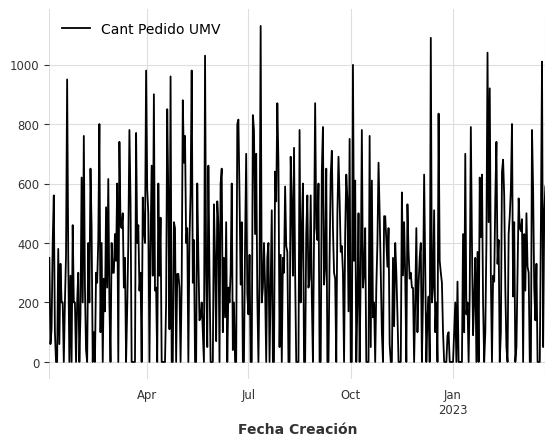

In [20]:
data.plot(y='Cant Pedido UMV',x='Fecha Creación')

In [150]:
filler = MissingValuesFiller()

data = filler.transform(
    TimeSeries.from_dataframe(
        data, "Fecha Creación", ["Cant Pedido UMV"]
    )
)

In [152]:
train, val = data.split_after(pd.Timestamp("20230107"))

In [153]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(data)

In [154]:
model_nbeats.fit(train, val_series=val, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=10, output_chunk_length=4, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, model_name=nbeats_run, pl_trainer_kwargs={'enable_progress_bar': True, 'accelerator': 'gpu'})

In [155]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [156]:
pred_series = model_nbeats.historical_forecasts(
    data,
    start=pd.Timestamp("20230107"),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/69 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

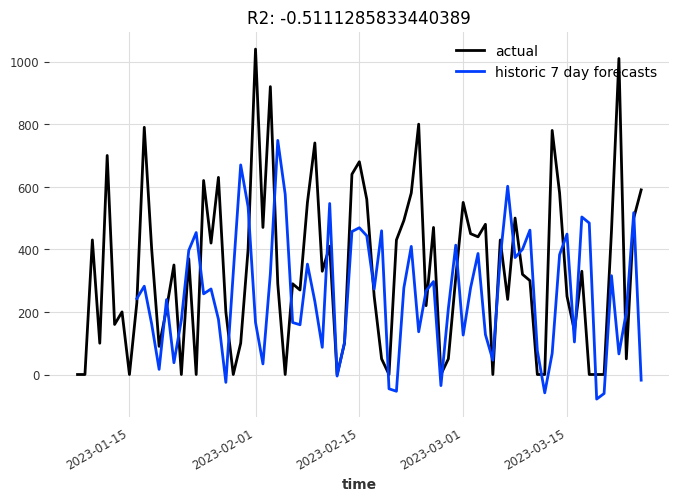

In [157]:
display_forecast(pred_series, series, "7 day", start_date=pd.Timestamp("20230107"))

In [5]:
from factory_models import ModelContext, Modelos

In [5]:
parameters_train = {
    "model_name":'Test_model',
    "model": "LSTM",
    "hidden_dim": 20,
    "dropout": 0,
    "batch_size": 16,
    "n_epochs": 300,
    "optimizer_kwargs":{"lr": 1e-3},
    "log_tensorboard": True,
    "random_state": 42,
    "training_length": 20,
    "input_chunk_length":14,
    "force_reset":True,
    "save_checkpoints":True
}

In [6]:
parameter_model = ModelRNN(**parameters_train)

In [7]:
parameter_model

ModelRNN(model_name='Test_model', model='LSTM', hidden_dim=20, dropout=0, batch_size=16, n_epochs=300, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, training_length=20, input_chunk_length=14, force_reset=True, save_checkpoints=True)

In [8]:
ModelContext(model_name='RNNModel',parameters=parameter_model)

Modelo importado RNNModel
